# 🔊 데이터 증강 (Data Augmentation)

이 노트북에서는 클래스 불균형을 해결하기 위해 데이터 증강을 수행합니다.

**목표:**
- 소수 클래스의 샘플 수를 증강하여 균형 맞추기
- 다양한 증강 기법 시연 및 적용
- 증강된 데이터 저장


In [13]:
# ============================================================
# 필수 라이브러리 임포트
# ============================================================

import os
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf  # 오디오 파일 저장용
from pathlib import Path
from tqdm import tqdm  # 진행률 표시
import warnings
warnings.filterwarnings('ignore')

# 프로젝트 모듈
from app.ml.features.augmentation import AudioAugmentor, AugmentationConfig

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 라이브러리 로드 완료!")


✅ 라이브러리 로드 완료!


## 1. 현재 데이터 분포 확인


In [14]:
# ============================================================
# 현재 클래스별 샘플 수 확인
# ============================================================

data_dir = Path('../data')

# 클래스별 정보 수집
class_info = []

for state_dir in sorted(data_dir.iterdir()):
    if not state_dir.is_dir() or state_dir.name == 'augmented':
        continue
    
    for problem_dir in sorted(state_dir.iterdir()):
        if not problem_dir.is_dir():
            continue
        
        # WAV 파일 수집
        wav_files = list(problem_dir.glob('*.wav'))
        
        # 하위 폴더 확인 (combined 등)
        for sub_dir in problem_dir.iterdir():
            if sub_dir.is_dir():
                sub_files = list(sub_dir.glob('*.wav'))
                class_info.append({
                    'state': state_dir.name,
                    'problem': f"{problem_dir.name}/{sub_dir.name}",
                    'count': len(sub_files),
                    'path': str(sub_dir)
                })
        
        if wav_files:
            class_info.append({
                'state': state_dir.name,
                'problem': problem_dir.name,
                'count': len(wav_files),
                'path': str(problem_dir)
            })

df_class = pd.DataFrame(class_info)

# 통계 출력
max_count = df_class['count'].max()
min_count = df_class['count'].min()
mean_count = df_class['count'].mean()

print("=" * 60)
print("📊 현재 클래스 분포")
print("=" * 60)
print(f"\n총 클래스 수: {len(df_class)}개")
print(f"총 샘플 수: {df_class['count'].sum()}개")
print(f"\n최대 샘플 수: {max_count}개")
print(f"최소 샘플 수: {min_count}개")
print(f"평균 샘플 수: {mean_count:.1f}개")
print(f"\n불균형 비율: {max_count / min_count:.1f}배")
print("\n" + "=" * 60)

# 정렬하여 출력
df_class_sorted = df_class.sort_values('count', ascending=True)
print("\n📋 클래스별 샘플 수 (오름차순):")
for _, row in df_class_sorted.iterrows():
    bar = '█' * int(row['count'] / 10)
    print(f"  {row['problem']:45s} {row['count']:4d}개 {bar}")


📊 현재 클래스 분포

총 클래스 수: 13개
총 샘플 수: 1386개

최대 샘플 수: 264개
최소 샘플 수: 57개
평균 샘플 수: 106.6개

불균형 비율: 4.6배


📋 클래스별 샘플 수 (오름차순):
  dead_battery                                    57개 █████
  normal_engine_startup                           61개 ██████
  bad_ignition                                    62개 ██████
  worn_out_brakes                                 76개 ███████
  normal_brakes                                   77개 ███████
  combined/power steering combined_no oil_serpentine belt  107개 ██████████
  combined/no oil_serpentine belt                107개 ██████████
  combined/power steering combined_no oil        107개 ██████████
  low_oil                                        107개 ██████████
  combined/power steering combined_serpentine belt  116개 ███████████
  serpentine_belt                                116개 ███████████
  power_steering                                 129개 ████████████
  normal_engine_idle                             264개 ██████████████████████████


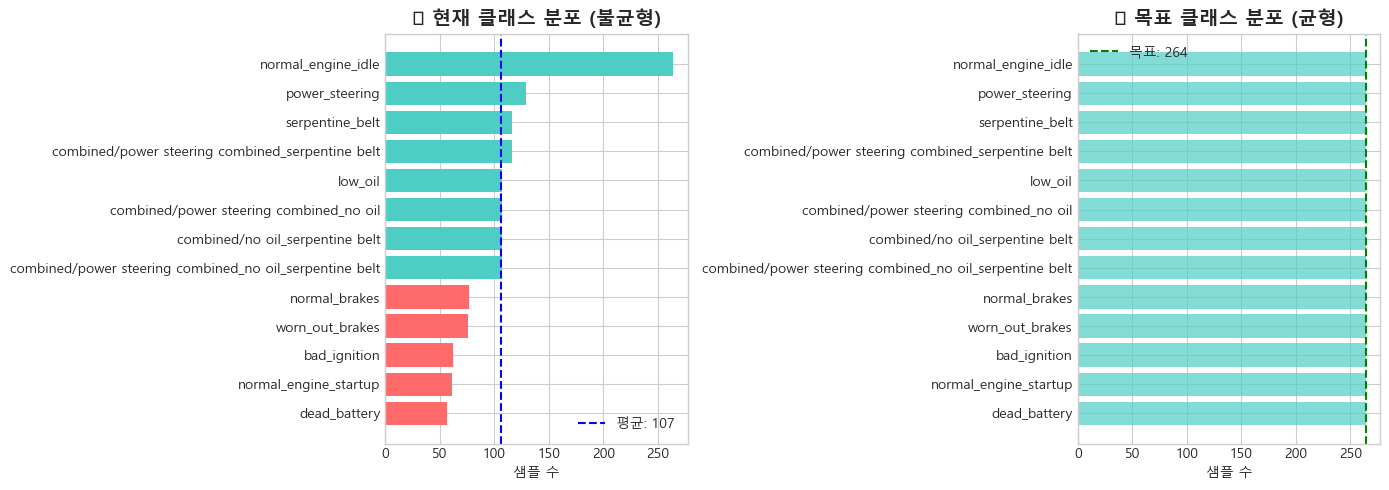


💡 각 클래스를 264개로 맞추면 총 3432개 샘플이 됩니다.


In [15]:
# ============================================================
# 불균형 시각화
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 좌측: 현재 분포
colors = ['#FF6B6B' if c < mean_count else '#4ECDC4' for c in df_class_sorted['count']]
axes[0].barh(df_class_sorted['problem'], df_class_sorted['count'], color=colors)
axes[0].axvline(x=mean_count, color='blue', linestyle='--', label=f'평균: {mean_count:.0f}')
axes[0].set_xlabel('샘플 수')
axes[0].set_title('📊 현재 클래스 분포 (불균형)', fontsize=14, fontweight='bold')
axes[0].legend()

# 우측: 목표 분포 (균형)
target_count = int(max_count)  # 최대 샘플 수에 맞춤
axes[1].barh(df_class_sorted['problem'], [target_count] * len(df_class_sorted), color='#4ECDC4', alpha=0.7)
axes[1].axvline(x=target_count, color='green', linestyle='--', label=f'목표: {target_count}')
axes[1].set_xlabel('샘플 수')
axes[1].set_title('🎯 목표 클래스 분포 (균형)', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n💡 각 클래스를 {target_count}개로 맞추면 총 {target_count * len(df_class)}개 샘플이 됩니다.")


## 2. 증강 기법 시연

다양한 오디오 증강 기법을 시각적으로 확인합니다.


In [16]:
# ============================================================
# 증강기 초기화 및 샘플 로드
# ============================================================

# 증강 설정
aug_config = AugmentationConfig(
    time_stretch_rate_min=0.85,
    time_stretch_rate_max=1.15,
    pitch_shift_steps_min=-3,
    pitch_shift_steps_max=3,
    noise_factor_min=0.002,
    noise_factor_max=0.01,
    volume_factor_min=0.7,
    volume_factor_max=1.3,
    time_shift_max=0.15
)

augmentor = AudioAugmentor(config=aug_config)

# 샘플 오디오 로드 (소수 클래스에서 선택)
sample_path = list((data_dir / 'startup state' / 'dead_battery').glob('*.wav'))[0]
y_original, sr = librosa.load(str(sample_path), sr=22050)

print(f"✅ 샘플 로드: {sample_path.name}")
print(f"   길이: {len(y_original)/sr:.2f}초, SR: {sr}Hz")


✅ 샘플 로드: dead_battery_1.wav
   길이: 1.70초, SR: 22050Hz


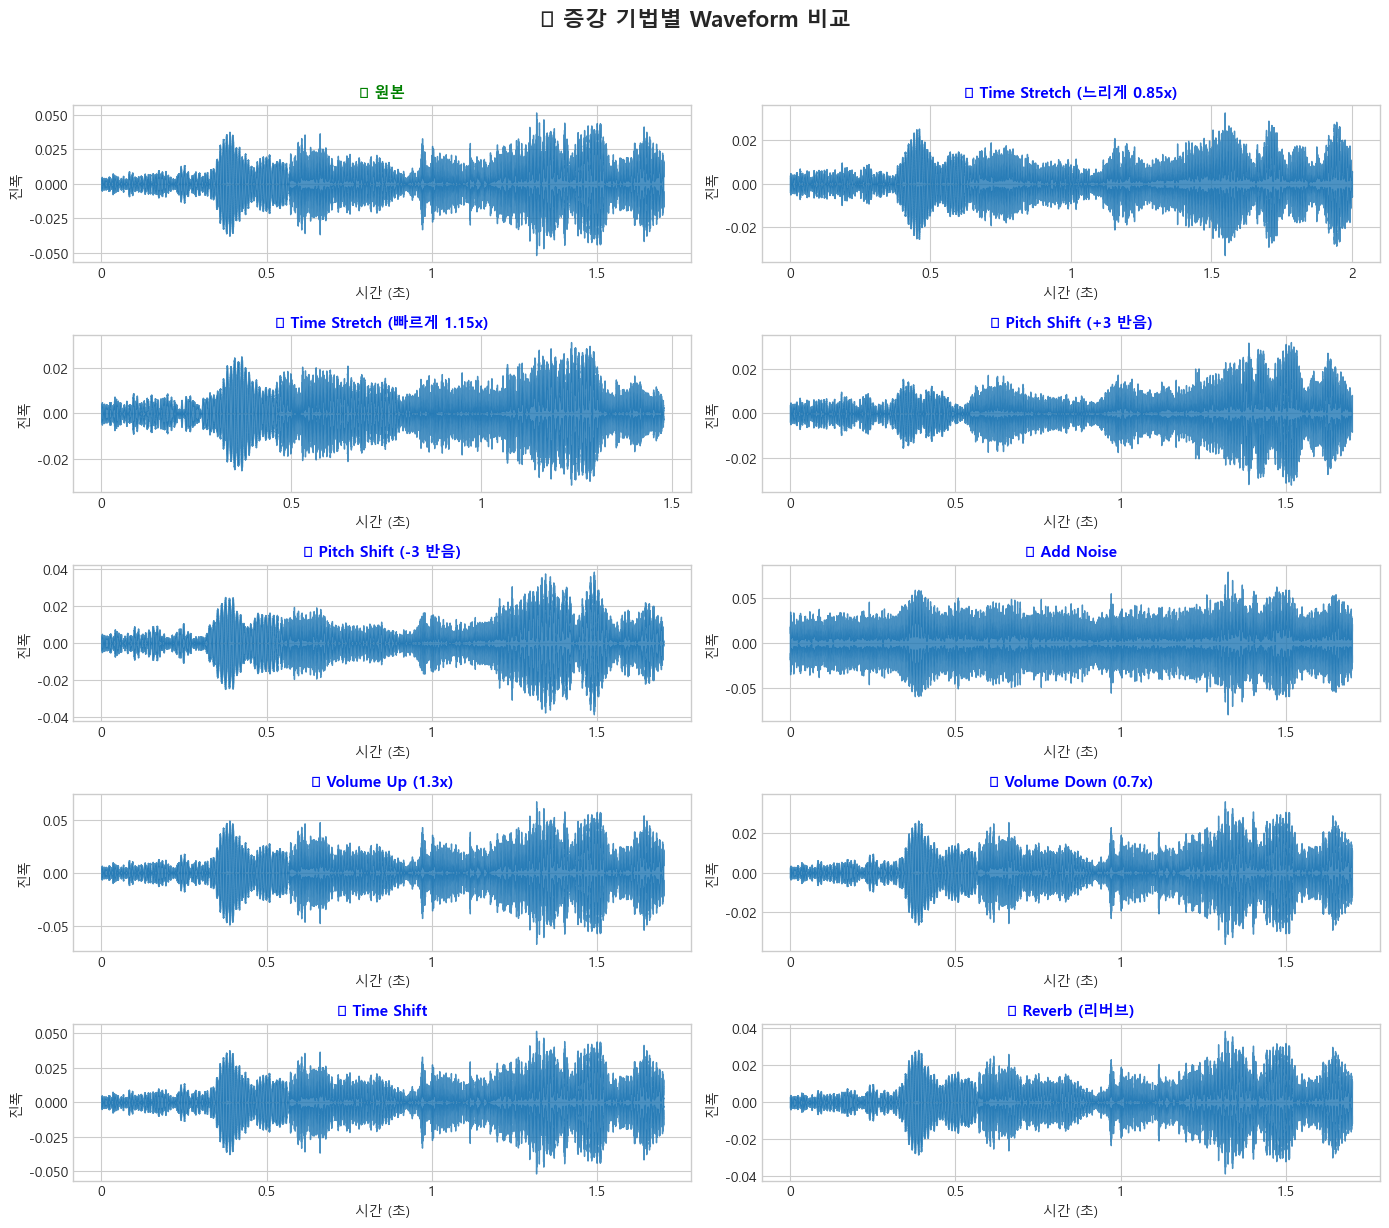


💡 각 증강 기법은 소리의 다른 특성을 변형합니다:
   • Time Stretch: 재생 속도 변경 (RPM 변화 시뮬레이션)
   • Pitch Shift: 주파수 변경 (엔진 크기 차이 시뮬레이션)
   • Add Noise: 배경 소음 추가
   • Volume: 마이크 거리/감도 차이 시뮬레이션
   • Time Shift: 녹음 시작점 변경
   • Reverb: 실내/실외 환경 차이 시뮬레이션


In [ ]:
# ============================================================
# 각 증강 기법 적용 및 Waveform 비교
# ============================================================

# 증강 적용
augmentations = {
    '원본': y_original,
    'Time Stretch (느리게 0.85x)': augmentor.time_stretch(y_original, rate=0.85),
    'Time Stretch (빠르게 1.15x)': augmentor.time_stretch(y_original, rate=1.15),
    'Pitch Shift (+3 반음)': augmentor.pitch_shift(y_original, int(sr), n_steps=3),
    'Pitch Shift (-3 반음)': augmentor.pitch_shift(y_original, int(sr), n_steps=-3),
    'Add Noise': augmentor.add_noise(y_original, noise_factor=0.01),
    'Volume Up (1.3x)': augmentor.change_volume(y_original, factor=1.3),
    'Volume Down (0.7x)': augmentor.change_volume(y_original, factor=0.7),
    'Time Shift': augmentor.time_shift(y_original),
    'Reverb (리버브)': augmentor.add_reverb(y_original, int(sr))
}

# Waveform 비교
fig, axes = plt.subplots(5, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (name, y_aug) in enumerate(augmentations.items()):
    librosa.display.waveshow(y_aug, sr=sr, ax=axes[idx], alpha=0.8)
    color = 'green' if name == '원본' else 'blue'
    axes[idx].set_title(f'🔊 {name}', fontsize=11, color=color, fontweight='bold')
    axes[idx].set_xlabel('시간 (초)')
    axes[idx].set_ylabel('진폭')

plt.suptitle('📊 증강 기법별 Waveform 비교', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 각 증강 기법은 소리의 다른 특성을 변형합니다:")
print("   • Time Stretch: 재생 속도 변경 (RPM 변화 시뮬레이션)")
print("   • Pitch Shift: 주파수 변경 (엔진 크기 차이 시뮬레이션)")
print("   • Add Noise: 배경 소음 추가")
print("   • Volume: 마이크 거리/감도 차이 시뮬레이션")
print("   • Time Shift: 녹음 시작점 변경")
print("   • Reverb: 실내/실외 환경 차이 시뮬레이션")


## 3. 데이터 증강 적용

부족한 클래스에 증강을 적용하여 균형을 맞춥니다.


In [18]:
# ============================================================
# 증강 필요 클래스 및 개수 계산
# ============================================================

# 목표: 모든 클래스를 최대 샘플 수에 맞춤
target_samples = int(df_class['count'].max())

print(f"🎯 목표 샘플 수: {target_samples}개/클래스")
print("\n" + "=" * 60)
print("📋 증강 계획:")
print("=" * 60)

augmentation_plan = []

for _, row in df_class.iterrows():
    current = row['count']
    needed = target_samples - current
    
    if needed > 0:
        # 증강 배수 계산 (원본 1개당 몇 개 생성?)
        aug_per_sample = int(np.ceil(needed / current))
        actual_aug = current * aug_per_sample
        
        augmentation_plan.append({
            'problem': row['problem'],
            'path': row['path'],
            'current': current,
            'needed': needed,
            'aug_per_sample': aug_per_sample,
            'final': current + actual_aug
        })
        
        print(f"  {row['problem']:45s}")
        print(f"     현재: {current:3d}개 → 필요: +{needed:3d}개 (원본당 {aug_per_sample}개 증강)")
    else:
        print(f"  {row['problem']:45s} ✓ 충분 ({current}개)")

print("\n" + "=" * 60)
print(f"총 {len(augmentation_plan)}개 클래스에 증강 필요")


🎯 목표 샘플 수: 264개/클래스

📋 증강 계획:
  normal_brakes                                
     현재:  77개 → 필요: +187개 (원본당 3개 증강)
  worn_out_brakes                              
     현재:  76개 → 필요: +188개 (원본당 3개 증강)
  combined/no oil_serpentine belt              
     현재: 107개 → 필요: +157개 (원본당 2개 증강)
  combined/power steering combined_no oil      
     현재: 107개 → 필요: +157개 (원본당 2개 증강)
  combined/power steering combined_no oil_serpentine belt
     현재: 107개 → 필요: +157개 (원본당 2개 증강)
  combined/power steering combined_serpentine belt
     현재: 116개 → 필요: +148개 (원본당 2개 증강)
  low_oil                                      
     현재: 107개 → 필요: +157개 (원본당 2개 증강)
  normal_engine_idle                            ✓ 충분 (264개)
  power_steering                               
     현재: 129개 → 필요: +135개 (원본당 2개 증강)
  serpentine_belt                              
     현재: 116개 → 필요: +148개 (원본당 2개 증강)
  bad_ignition                                 
     현재:  62개 → 필요: +202개 (원본당 4개 증강)
  dead_battery                       

In [ ]:
# ============================================================
# 증강 데이터 저장 디렉토리 및 함수 정의
# ============================================================

augmented_dir = data_dir / 'augmented'
augmented_dir.mkdir(exist_ok=True)

def augment_and_save(
    source_path: Path,
    output_dir: Path,
    augmentor: AudioAugmentor,
    num_augmented: int,
    sr: int = 22050
) -> int:
    """
    오디오 파일을 증강하고 저장하는 함수
    
    Parameters:
    -----------
    source_path : Path - 원본 오디오 파일 경로
    output_dir : Path - 증강된 파일 저장 디렉토리
    augmentor : AudioAugmentor - 증강기 인스턴스
    num_augmented : int - 생성할 증강 샘플 수
    sr : int - 샘플링 레이트
    """
    # Path로 변환 (타입 안전성)
    source_path = Path(source_path)  # type: ignore
    output_dir = Path(output_dir)  # type: ignore
    
    # 오디오 로드
    y, _ = librosa.load(str(source_path), sr=sr)
    
    # 파일명에서 기본 이름 추출
    base_name = source_path.stem
    
    # 증강 생성 및 저장
    for i in range(num_augmented):
        # 랜덤 증강 적용
        y_aug = augmentor.augment(y, sr)
        
        # 저장
        output_path = output_dir / f"{base_name}_aug{i+1}.wav"
        sf.write(str(output_path), y_aug, sr)
    
    return num_augmented

print(f"📁 증강 데이터 저장 경로: {augmented_dir}")
print("✅ 증강 함수 정의 완료!")


📁 증강 데이터 저장 경로: ..\data\augmented
✅ 증강 함수 정의 완료!


In [ ]:
# ============================================================
# 증강 실행 (실제 파일 생성)
# ⚠️ 이 셀은 실행에 시간이 걸릴 수 있습니다!
# ============================================================

print("🚀 데이터 증강 시작!")
print("=" * 60)

total_augmented = 0

for plan in tqdm(augmentation_plan, desc="클래스 처리"):
    problem = plan['problem']
    source_dir = Path(str(plan['path']))
    aug_per_sample = plan['aug_per_sample']
    
    # 증강 데이터 저장 폴더 생성 (원본 구조 유지)
    relative_path = source_dir.relative_to(data_dir)
    output_dir = augmented_dir / relative_path
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # 원본 파일들에 대해 증강
    wav_files = list(source_dir.glob('*.wav'))
    
    for wav_file in wav_files:
        count = augment_and_save(
            source_path=wav_file,
            output_dir=output_dir,
            augmentor=augmentor,
            num_augmented=aug_per_sample
        )
        total_augmented += count

print("\n" + "=" * 60)
print(f"✅ 증강 완료!")
print(f"   생성된 증강 샘플: {total_augmented}개")
print(f"   저장 위치: {augmented_dir}")


🚀 데이터 증강 시작!


클래스 처리: 100%|██████████| 12/12 [00:54<00:00,  4.55s/it]


✅ 증강 완료!
   생성된 증강 샘플: 2757개
   저장 위치: ..\data\augmented


## 4. 증강 결과 확인


In [ ]:
# ============================================================
# 증강 후 데이터 분포 확인
# ============================================================

# 원본 + 증강 합계 계산
final_counts = []

for _, row in df_class.iterrows():
    original_path = Path(str(row['path']))
    original_count = row['count']
    
    # 증강 폴더 확인
    relative_path = original_path.relative_to(data_dir)
    aug_path = augmented_dir / relative_path
    
    aug_count = 0
    if aug_path.exists():
        aug_count = len(list(aug_path.glob('*.wav')))
    
    final_counts.append({
        'problem': row['problem'],
        'original': original_count,
        'augmented': aug_count,
        'total': original_count + aug_count
    })

df_final = pd.DataFrame(final_counts)

print("=" * 60)
print("📊 증강 후 데이터 분포")
print("=" * 60)
print(f"\n원본 샘플: {df_final['original'].sum()}개")
print(f"증강 샘플: {df_final['augmented'].sum()}개")
print(f"총 샘플: {df_final['total'].sum()}개")
print("\n")
print(df_final.to_string(index=False))


📊 증강 후 데이터 분포

원본 샘플: 1386개
증강 샘플: 2757개
총 샘플: 4143개


                                                problem  original  augmented  total
                                          normal_brakes        77        231    308
                                        worn_out_brakes        76        228    304
                        combined/no oil_serpentine belt       107        214    321
                combined/power steering combined_no oil       107        214    321
combined/power steering combined_no oil_serpentine belt       107        214    321
       combined/power steering combined_serpentine belt       116        232    348
                                                low_oil       107        214    321
                                     normal_engine_idle       264          0    264
                                         power_steering       129        258    387
                                        serpentine_belt       116        232    348
                     

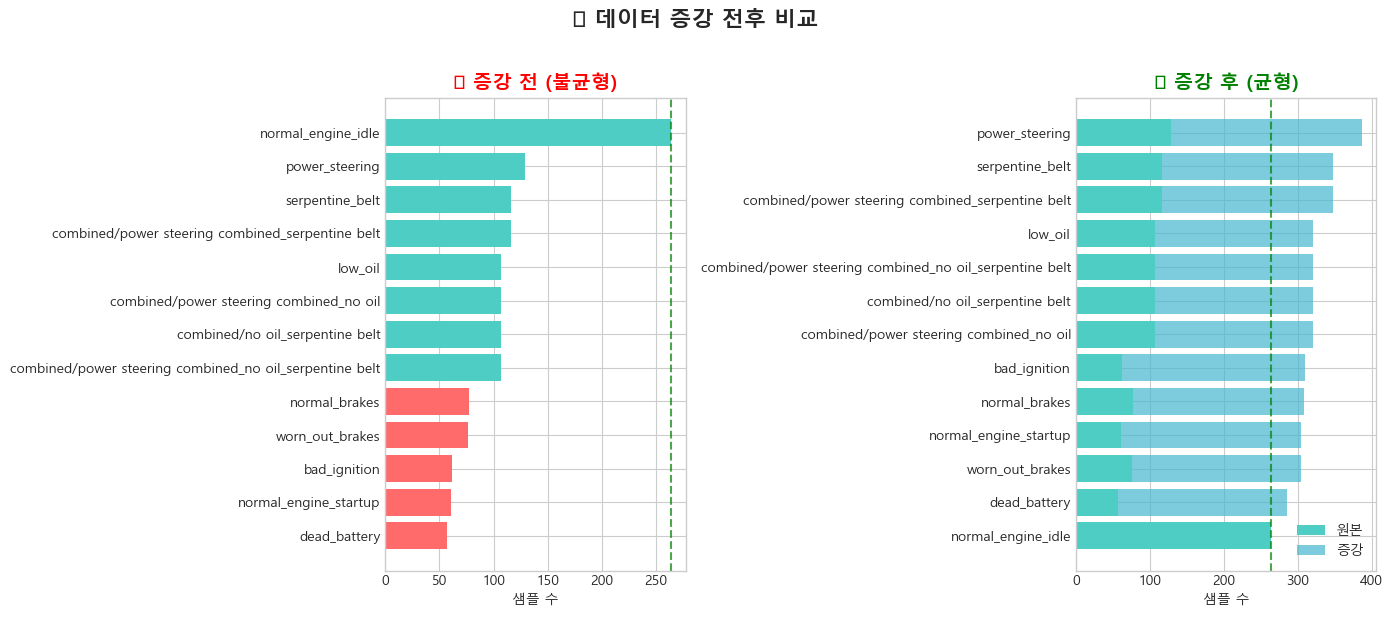

In [22]:
# ============================================================
# 증강 전후 비교 시각화
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 좌측: 증강 전
df_sorted = df_class.sort_values('count')
colors_before = ['#FF6B6B' if c < mean_count else '#4ECDC4' for c in df_sorted['count']]
axes[0].barh(df_sorted['problem'], df_sorted['count'], color=colors_before)
axes[0].axvline(x=target_samples, color='green', linestyle='--', alpha=0.7)
axes[0].set_xlabel('샘플 수')
axes[0].set_title('📊 증강 전 (불균형)', fontsize=14, fontweight='bold', color='red')

# 우측: 증강 후
df_final_sorted = df_final.sort_values('total')
axes[1].barh(df_final_sorted['problem'], df_final_sorted['original'], 
             color='#4ECDC4', label='원본')
axes[1].barh(df_final_sorted['problem'], df_final_sorted['augmented'], 
             left=df_final_sorted['original'], color='#45B7D1', label='증강', alpha=0.7)
axes[1].axvline(x=target_samples, color='green', linestyle='--', alpha=0.7)
axes[1].set_xlabel('샘플 수')
axes[1].set_title('📊 증강 후 (균형)', fontsize=14, fontweight='bold', color='green')
axes[1].legend()

plt.suptitle('🔄 데이터 증강 전후 비교', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 5. 요약


In [23]:
# ============================================================
# 데이터 증강 완료 요약
# ============================================================

print("=" * 60)
print("🎉 데이터 증강 완료!")
print("=" * 60)

print(f"""
📊 증강 요약:
  • 원본 샘플: {df_final['original'].sum()}개
  • 증강 샘플: {df_final['augmented'].sum()}개
  • 총 샘플: {df_final['total'].sum()}개
  
🔧 사용된 증강 기법:
  • Time Stretch (시간 스트레칭) - RPM 변화 시뮬레이션
  • Pitch Shift (피치 시프트) - 엔진 크기 차이 시뮬레이션
  • Add Noise (노이즈 추가) - 배경 소음 시뮬레이션
  • Volume Change (볼륨 변경) - 마이크 거리 차이 시뮬레이션
  • Time Shift (시간 시프트) - 녹음 시작점 변화

📁 저장 위치:
  • 원본: data/[state]/[problem]/
  • 증강: data/augmented/[state]/[problem]/

💡 다음 단계:
  1. 모델 학습 시 원본 + 증강 데이터 함께 사용
  2. SpecAugment는 학습 중 실시간으로 적용 권장
  3. CNN/CRNN 모델 학습 진행
""")
print("=" * 60)


🎉 데이터 증강 완료!

📊 증강 요약:
  • 원본 샘플: 1386개
  • 증강 샘플: 2757개
  • 총 샘플: 4143개

🔧 사용된 증강 기법:
  • Time Stretch (시간 스트레칭) - RPM 변화 시뮬레이션
  • Pitch Shift (피치 시프트) - 엔진 크기 차이 시뮬레이션
  • Add Noise (노이즈 추가) - 배경 소음 시뮬레이션
  • Volume Change (볼륨 변경) - 마이크 거리 차이 시뮬레이션
  • Time Shift (시간 시프트) - 녹음 시작점 변화

📁 저장 위치:
  • 원본: data/[state]/[problem]/
  • 증강: data/augmented/[state]/[problem]/

💡 다음 단계:
  1. 모델 학습 시 원본 + 증강 데이터 함께 사용
  2. SpecAugment는 학습 중 실시간으로 적용 권장
  3. CNN/CRNN 모델 학습 진행

